In [51]:
#Loads some parameters
import CloudDataset128b
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
batch_size = 7

#imports state of the art model.
#model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50')
print("Load successfull")


Load successfull


<class 'torch.Tensor'>
torch.Size([7, 12, 128, 128])
torch.Size([7, 6, 128, 128])


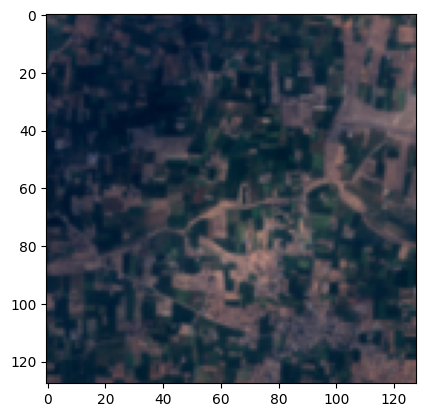

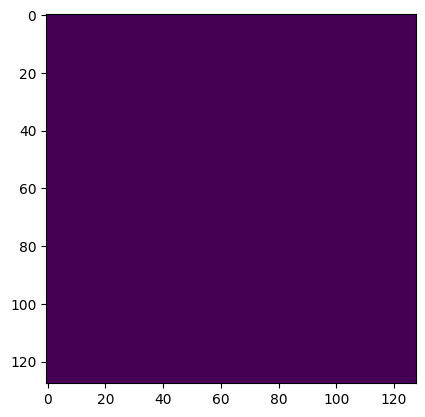

In [52]:
transform = {
    "image": transforms.Compose([
    transforms.Resize(size=(256,256)),
]),
    "mask": transforms.Compose([
    transforms.Resize(size=(256,256)),
])}

# Get the dataset of the CloudDataset
dataset = CloudDataset128b.CloudDataset("data\\train",transform=transform)

# Creates validation/training dataset with 20/80 split
validation_dataset, training_dataset = torch.utils.data.random_split(dataset,[0.2, 0.8])

# Create a DataLoaders from the datasets.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# Creates an iterator and plots the pictures
it = iter(training_loader)
images, labels = next(it)

print(type(images))
print(images.shape)
print(labels.shape)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=4
plt.imshow(labels[0][i:i+1].permute(1,2,0))
plt.show()

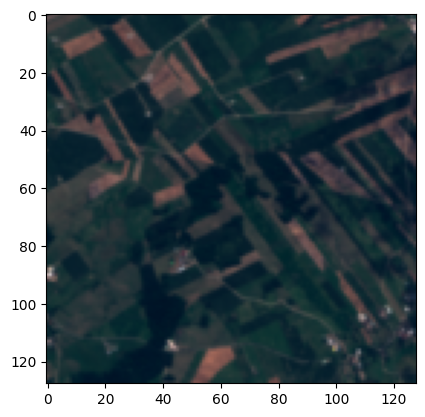

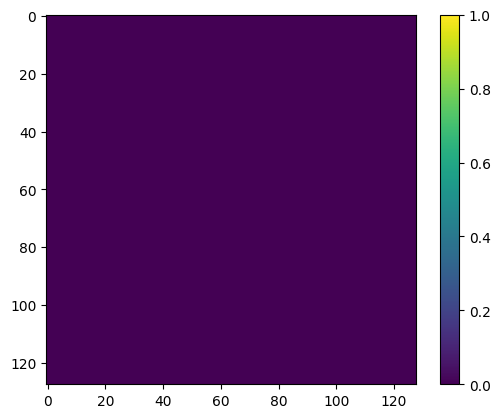

In [53]:
# Grabs next bath of pictures and displays the first, run multiple times for different plots
images, labels = next(it)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=4
img = plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0,vmax=1)
plt.colorbar(img)
plt.show()

In [54]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 128x128x12
        self.e11 = nn.Conv2d(12, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x64

        # input: 64x64x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x128

        # input: 32x32x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x256

        # input: 16x16x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x512

        # input: 8x8x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 4x4x1024

        # input: 4x4x1024
        self.e61 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1) # output: 4x4x2048
        self.e62 = nn.Conv2d(2048, 2048, kernel_size=3, padding=1) # output: 4x4x2048


        # Decoder
        # input: 4x4x2048
        self.upconv0 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2) # output: 8x8x2048
        self.d01 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.d02 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024


        # input: 8x8x1024
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 16x16x1024
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512

        # input: 16x16x512
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 32x32x512
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256

        # input: 32x32x256
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 64x64x256
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128

        # input: 64x64x128
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 128x128x128
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64

        # Output layer
        # input: 128x128x64
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1) # output: 128 x 128 x n_class

        #Dropout
        self.dropout = nn.Dropout(0.85)
    
    def forward(self, x):
        # Encoder
        #print(x.shape)
        xe11 = relu(self.e11(x))
        #print(xe11.shape)
        xe12 = relu(self.e12(xe11))
        #print(xe12.shape)
        xp1 = self.pool1(xe12)
        #print(xp1.shape)

        xe21 = relu(self.e21(xp1))
        #print(xe21.shape)
        xe22 = relu(self.e22(xe21))
        #print(xe22.shape)
        xp2 = self.pool2(xe22)
        #print(xp2.shape)

        xe31 = relu(self.e31(xp2))
        #print(xe31.shape)
        xe32 = relu(self.e32(xe31))
        #print(xe32.shape)
        xp3 = self.pool3(xe32)
        #print(xp3.shape)

        xe41 = relu(self.e41(xp3))
        #print(xe41.shape)
        xe42 = relu(self.e42(xe41))
        #print(xe42.shape)
        xp4 = self.pool4(xe42)
        #print(xp4.shape)

        xe51 = relu(self.e51(xp4))
        #print(xe51.shape)
        xe52 = relu(self.e52(xe51))
        #print(xe52.shape)
        #xp5 = self.pool5(xe52)
        #print(xp5.shape)

        #xe61 = relu(self.e61(xp5))
        #print(xe51.shape)
        #xe62 = relu(self.e62(xe61))
        #print(xe52.shape)
        
        # Decoder
        #xu0 = self.upconv0(xe62)
        #xu01 = torch.cat([xu0, xe52], dim=1)
        #xd01 = relu(self.d01(xu01))
        #xd02 = relu(self.d02(xd01))

        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out=self.outconv(xd42)

        return out

Epoch: 0 batch_nr: 0 Time: 2.797241299995221 Time_diff: 2.797243000008166 loss: 1.676151156425476
Epoch: 0 batch_nr: 8 Time: 50.67440019999049 Time_diff: 5.4752763000142295 loss: 2.0859209961361356

 New best loss: 2.8978660106658936


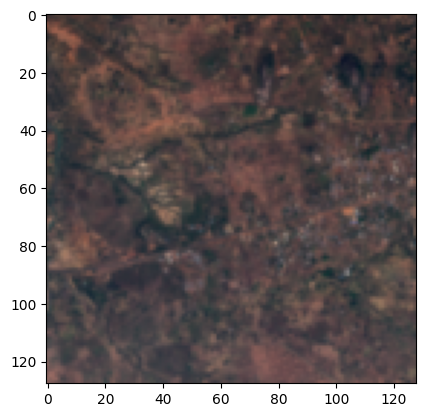

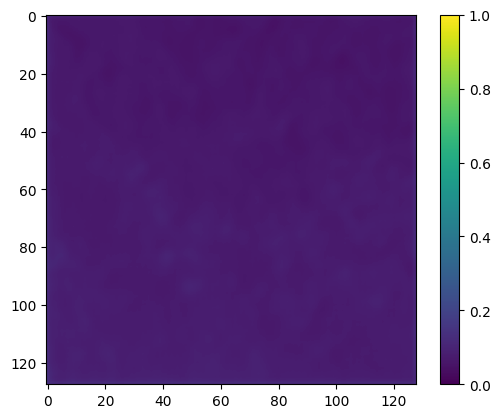

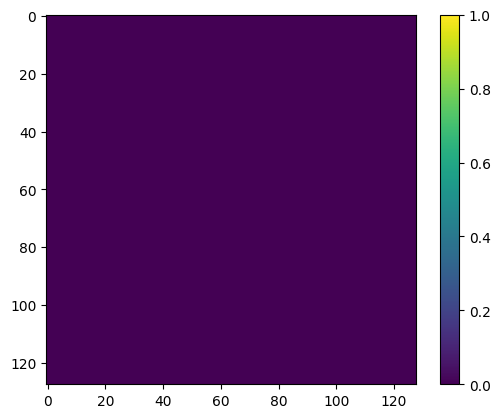

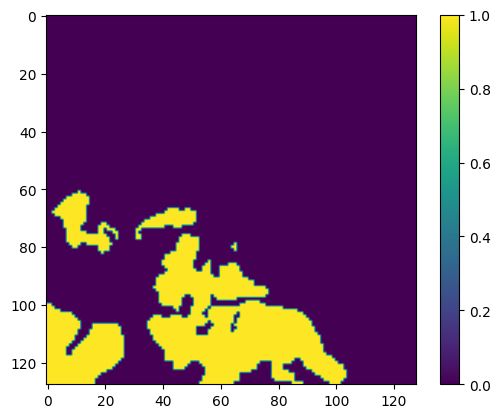

Epoch: 1 batch_nr: 7 Time: 110.66215739998734 Time_diff: 5.59753629998886 loss: 2.166414812207222

 New best loss: 1.5683040618896484


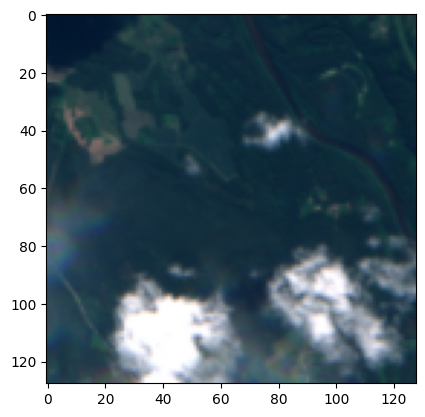

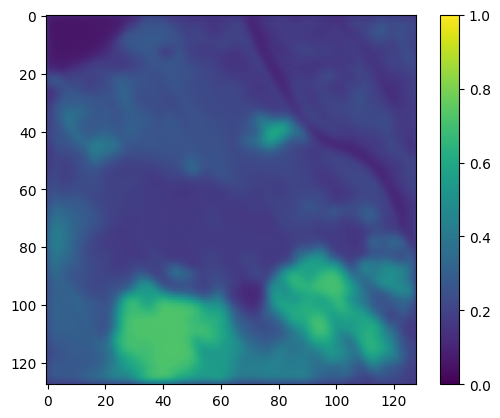

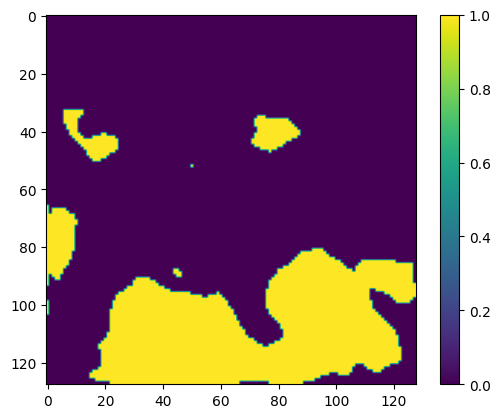

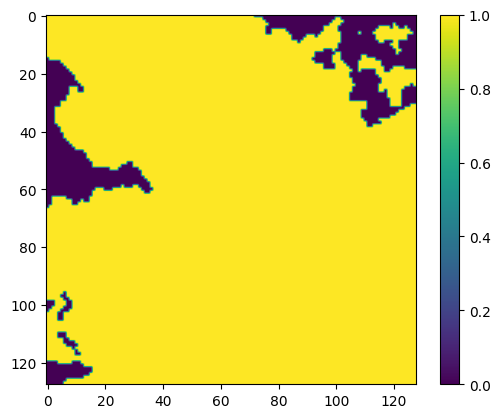

Epoch: 2 batch_nr: 6 Time: 167.5618273 Time_diff: 5.765345399995567 loss: 2.2849933079310825
new val loss: 1.6188310384750366
Epoch: 3 batch_nr: 5 Time: 220.4213477000012 Time_diff: 5.482777199998964 loss: 2.114172557989756
new val loss: 2.6541388034820557
Epoch: 4 batch_nr: 4 Time: 274.04104320000624 Time_diff: 5.487201900017681 loss: 1.8427538633346559
new val loss: 1.6273648738861084
Epoch: 5 batch_nr: 3 Time: 330.51322570000775 Time_diff: 5.664634399989154 loss: 2.42107155919075

 New best loss: 1.5469090938568115


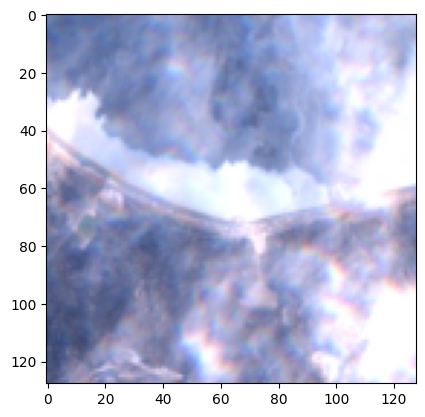

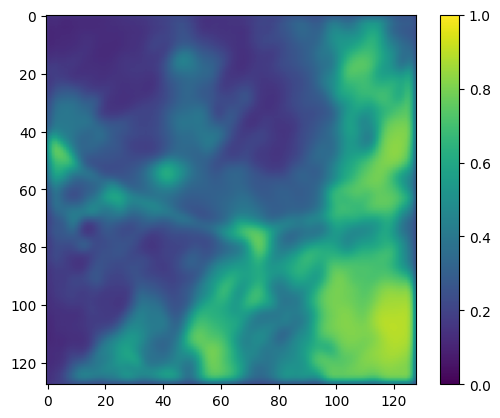

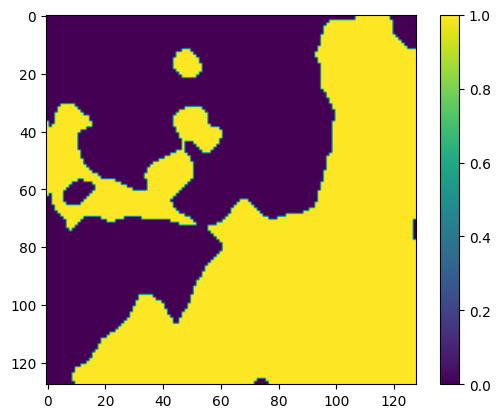

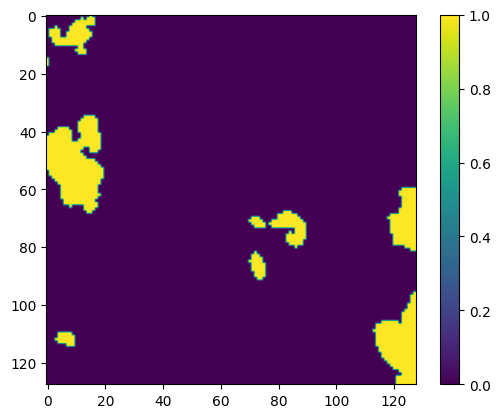

Epoch: 6 batch_nr: 2 Time: 398.0072383999941 Time_diff: 8.40487120000762 loss: 3.680914282798767
Epoch: 6 batch_nr: 10 Time: 453.41137909999816 Time_diff: 3.393275200010976 loss: 2.275211897763339
new val loss: 2.789499044418335
Epoch: 7 batch_nr: 1 Time: 468.1431875000126 Time_diff: 6.581807499984279 loss: 1.7246912121772766
Epoch: 7 batch_nr: 9 Time: 525.2971245000081 Time_diff: 6.387192199996207 loss: 1.94270179271698
new val loss: 1.6167019605636597
Epoch: 8 batch_nr: 0 Time: 536.6525941999862 Time_diff: 7.536903400003212 loss: 1.6610438823699951
Epoch: 8 batch_nr: 8 Time: 588.284481300012 Time_diff: 6.986388699995587 loss: 2.723955670992533
new val loss: 1.6550321578979492
Epoch: 9 batch_nr: 7 Time: 651.0298156999925 Time_diff: 6.238173499994446 loss: 1.936818204820156

 New best loss: 1.5249347686767578


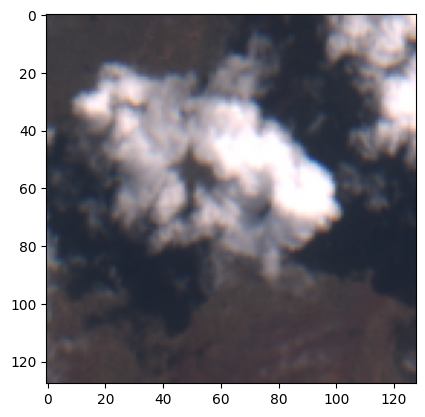

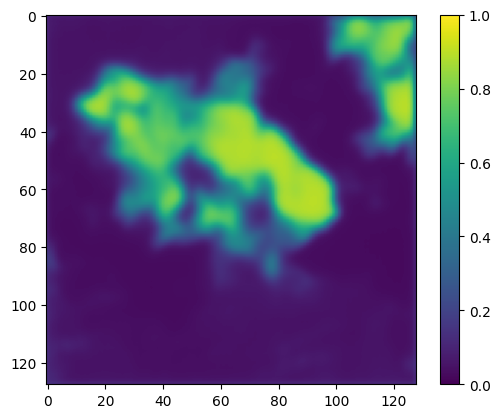

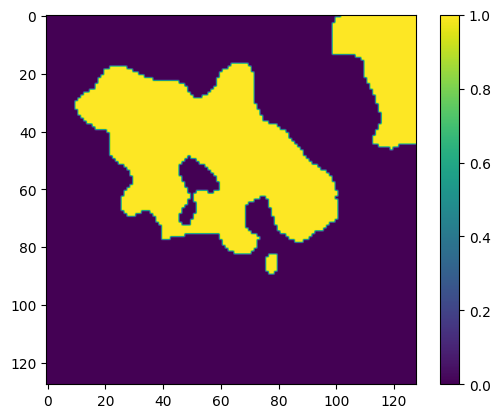

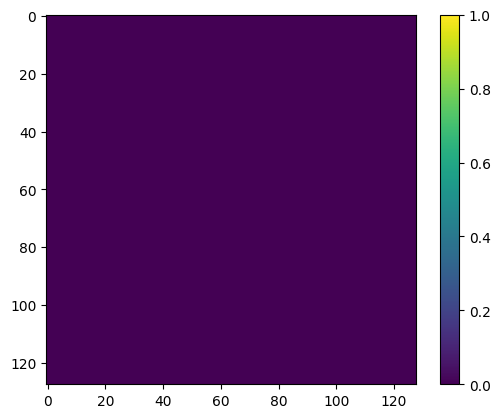

KeyboardInterrupt: 

In [5]:
import copy
from time import perf_counter
import random

epochs=500

def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler):
    start_time = perf_counter()
    time = 0


    best_loss = float('inf')

    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        avg_loss_list = []
        for batch_nr, (images,labels) in enumerate(train_loader):
            #Forward pass
            predictions = model(images)
            loss = criterion(predictions,labels.float())
            avg_loss_list.append(loss.item())
            
            if((batch_nr+epoch)%8==0):
                print("Epoch:",epoch,"batch_nr:",batch_nr,"Time:",perf_counter()-start_time,"Time_diff:",perf_counter()-start_time-time,"loss:",(sum(avg_loss_list)/len(avg_loss_list)))
            time=perf_counter()-start_time

            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
        
        #Grabs next iterator batch, restarts if at end of iterator
        try:
            images_valid, labels_valid = next(iterator)
        except:
            iterator = iter(val_loader)
            images_valid, labels_valid = next(iterator)


        #Forward - Validation
        predictions = model(images_valid)
        v_loss = criterion(predictions,labels_valid.float())
        
        train_loss.append((sum(avg_loss_list)/len(avg_loss_list)))
        val_loss.append(v_loss.item())

        #Finds best model
        if (v_loss<best_loss):
            best_loss=v_loss.item()
            best_model = copy.deepcopy(model)
            torch.save(model, 'best_UNET128b_model.pt')
            print("\n New best loss:",best_loss)

            
            plt.figure()
            plt.imshow(images_valid[0][:3].permute(1,2,0))
            plt.show()
            
            i=4

            predictions_softmax = nn.Softmax(dim=1)(predictions.detach())

            plt.figure()
            img=plt.imshow(predictions_softmax[0][i:i+1][:3].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()

            a = predictions_softmax.argmax (1)
            predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

            plt.figure()
            img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()


            plt.figure()
            img=plt.imshow(labels_valid[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()
        else:
            print("new val loss:",v_loss.item())
    
    plt.plot(range(1,epochs+1),train_loss, color='r', label='losses')
    plt.plot(range(1,epochs+1),val_loss, color='g', label='losses_valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return best_model

    

model = torch.load("best_UNET128b_model.pt")
optimizer = optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([627.9819277108434, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232, 7.415034213933109]))

best_model=train_model(training_loader,validation_loader,model,criterion,optimizer,scheduler)


In [55]:
test_dataset = CloudDataset128b.CloudDataset("data\\train",transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_it = iter(test_loader)
best_model = torch.load("best_UNET128b_model.pt")
criterion = nn.CrossEntropyLoss()
predictions = best_model(images)

In [56]:
images,labels = next(test_it)
predictions = best_model(images)

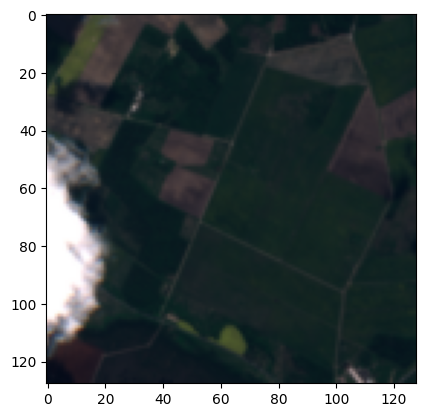

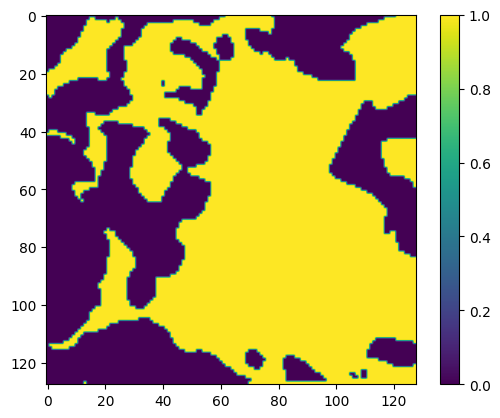

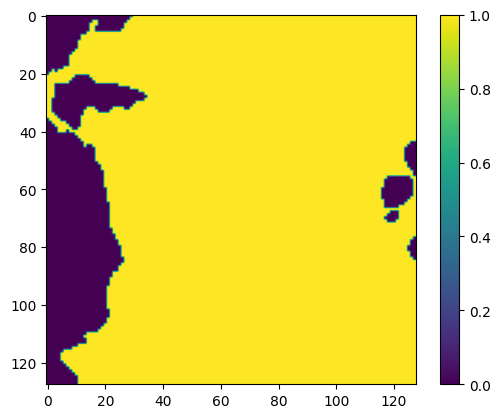

loss: tensor(1.2684, grad_fn=<DivBackward1>)


In [14]:

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()
i=1

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

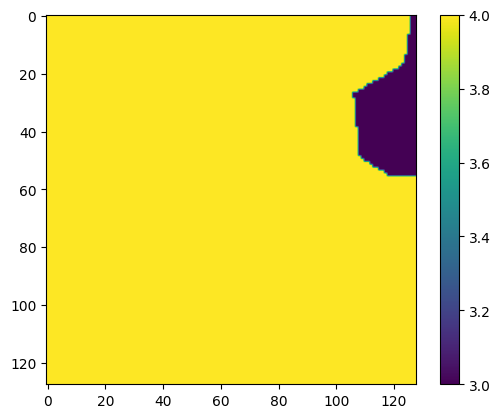

In [57]:
def from_one_hot(label):
    return np.argmax(label,0,keepdims=True)

l = (from_one_hot(labels[0]))

plt.figure()
img=plt.imshow(l.permute(1,2,0))
plt.colorbar(img)
plt.show()

In [35]:
images,labels = next(test_it)
predictions = best_model(images)

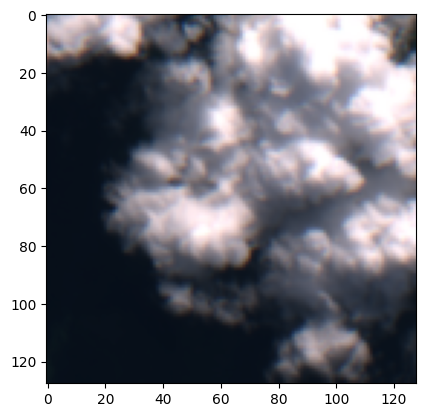

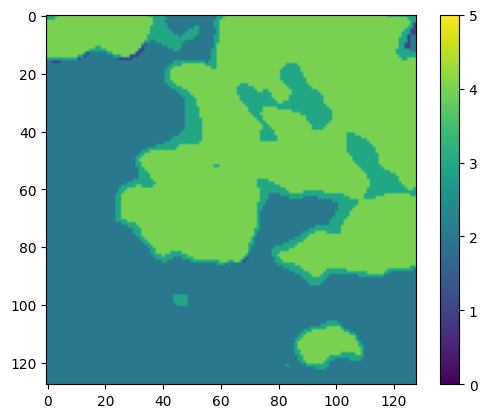

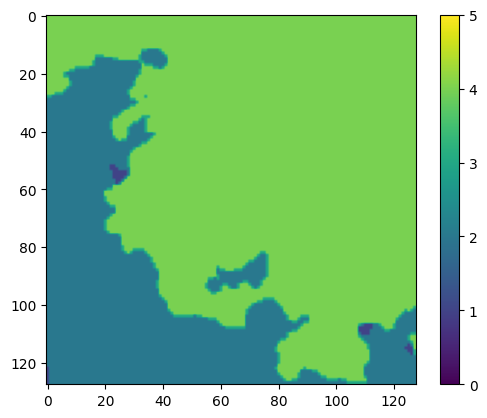

loss: tensor(1.0568, grad_fn=<DivBackward1>)


In [46]:
images,labels = next(test_it)
predictions = best_model(images)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

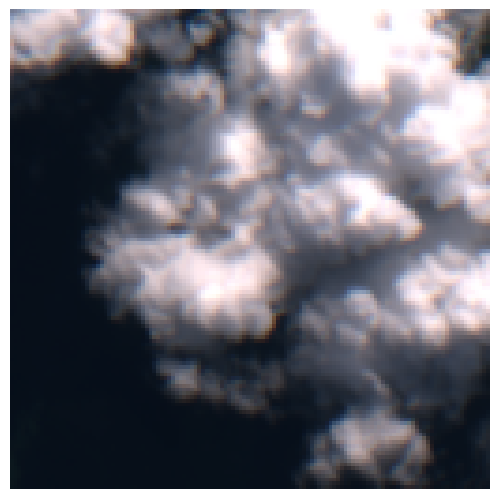

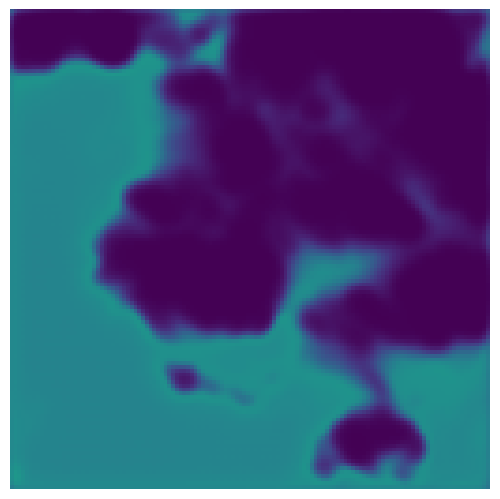

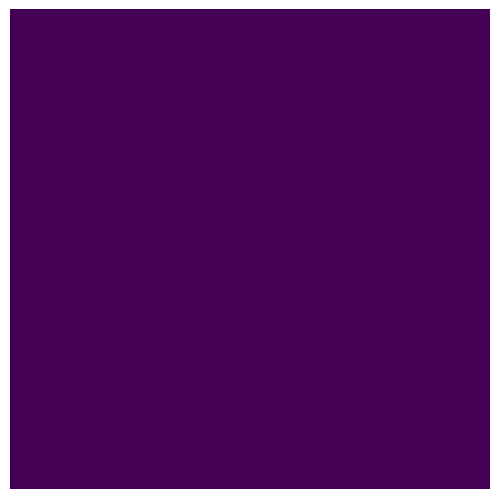

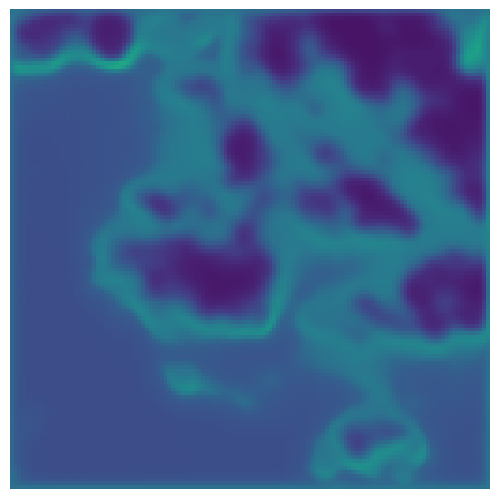

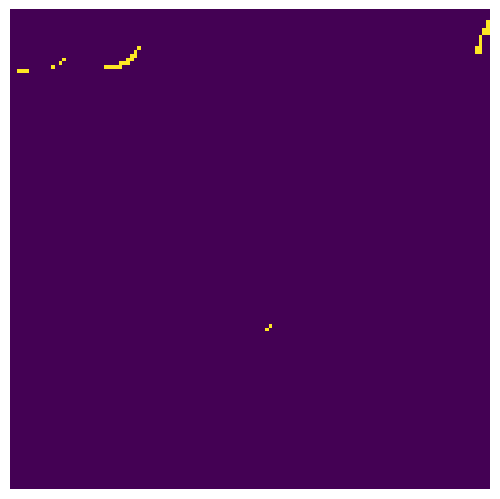

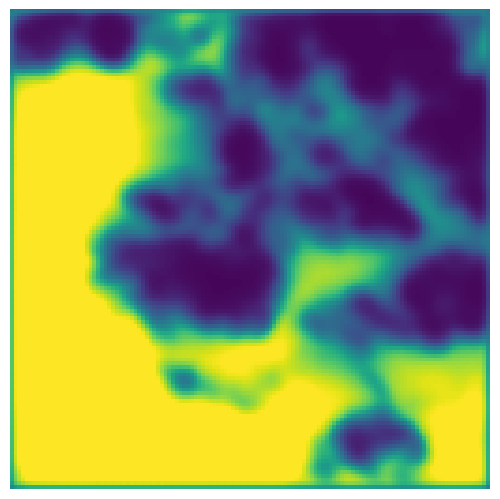

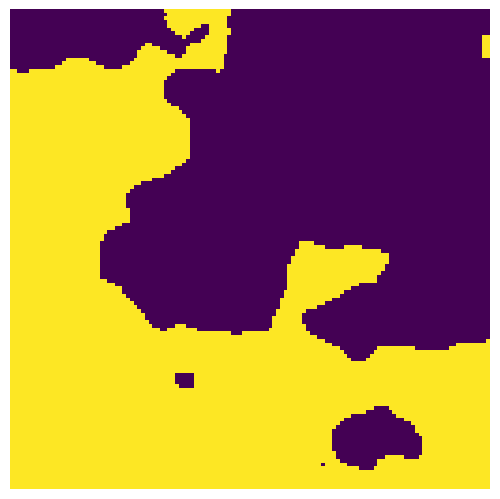

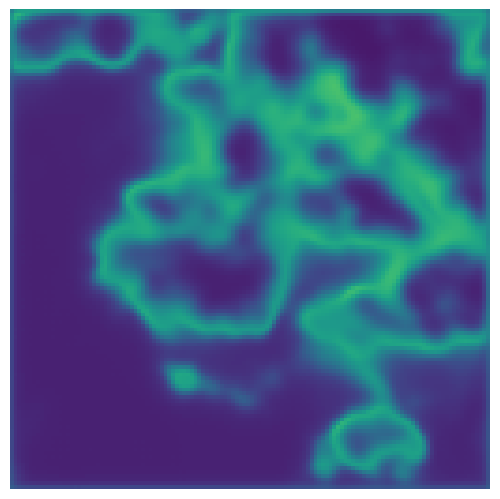

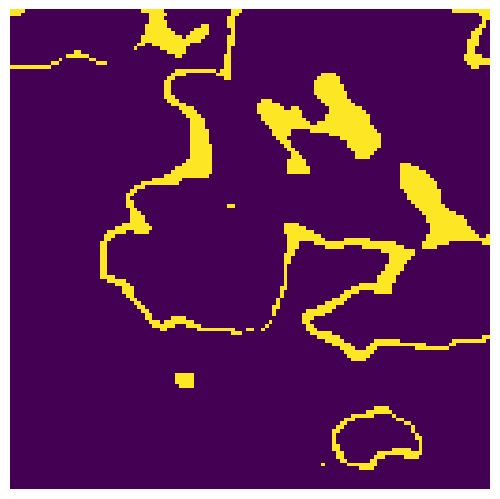

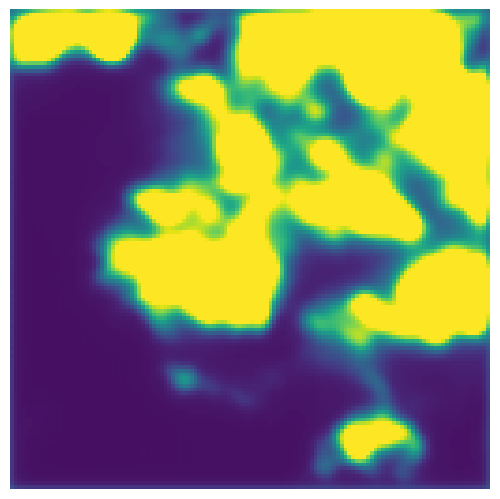

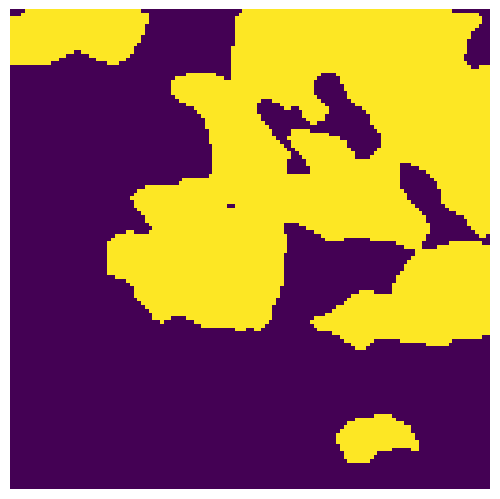

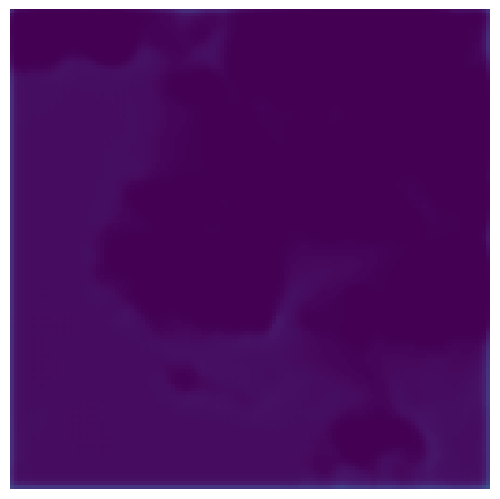

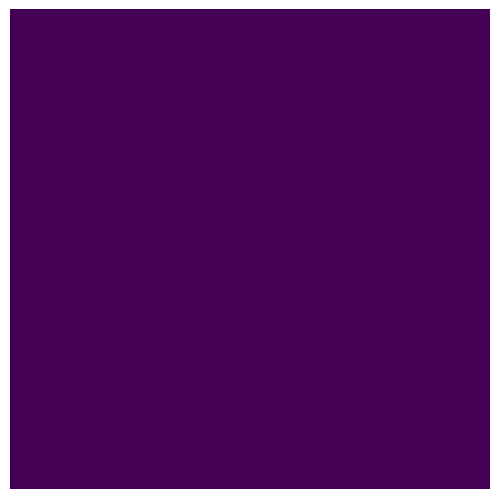

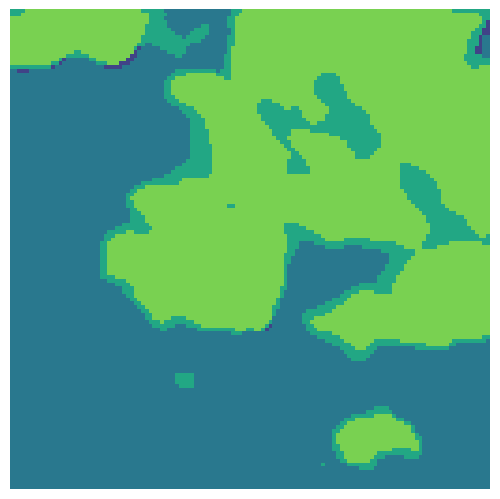

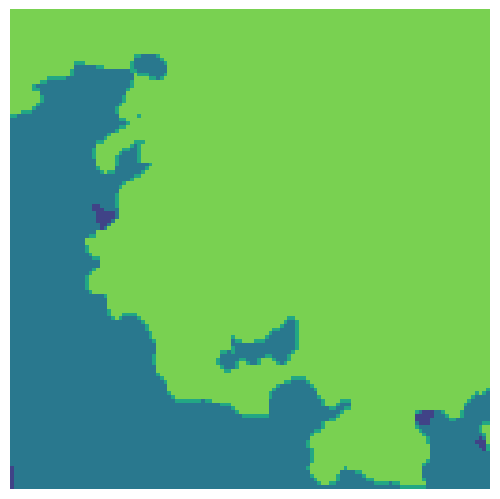

loss: tensor(1.0568, grad_fn=<DivBackward1>)


In [50]:
#For creating images

predictions = best_model(images)

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(images[0][:3].permute(1,2,0))
plt.savefig('img.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

for i in range(6):

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_softmax[0][i:i+1].permute(1,2,0),vmin=0, vmax=0.5)
    plt.savefig('softmax'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
    plt.savefig('binary'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()



fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('predictions.jpg', bbox_inches='tight',pad_inches=0)
plt.show()


fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('label.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

print("loss:",criterion(predictions,labels.float()))


In [63]:
_,labels = next(iter(training_loader))

In [81]:

vs = [0,0,0,0,0,0]
total=0
for batch_nr, (_,labels) in enumerate(training_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
for batch_nr, (_,labels) in enumerate(validation_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
print(vs)
m = max(vs)
for i, e in enumerate(vs):
    vs[i]=m/e
print(vs)

[830, 521225, 199987, 339080, 326761, 70293]
[627.9819277108434, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232, 7.415034213933109]


In [58]:
#Evaluate
total = 0
correct = 0

for batch_nr, (images, labels) in enumerate(training_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        y = torch.sum((pred==label))
        correct += y
        total += 128*128
        i+=1

print("Accuracy =", correct/total)

    

Accuracy = tensor(0.5886)


In [99]:
# IoU calculation

Union = [0,0,0,0,0,0] 
Intersection = [0,0,0,0,0,0]

for batch_nr, (images, labels) in enumerate(training_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        for p_class in range(6):
            inter=torch.sum((pred==label)*(label==p_class))
            uni = (torch.sum((label==p_class)) + torch.sum((label==p_class)) - inter)
            Intersection[p_class] += inter.item()
            Union[p_class] += uni.item()
        i+=1

for p_class in range(6):
    try:
        print("IoU, class=",p_class,":",Intersection[p_class]/Union[p_class])
    except:
        print("IoU, class=",p_class,":","NAN (Union=0)")

IoU, class= 0 : NAN (Union=0)
IoU, class= 1 : 0.35132111736918914
IoU, class= 2 : 0.482310973245444
IoU, class= 3 : 0.22519547417720798
IoU, class= 4 : 0.46268417680973734
IoU, class= 5 : 1.0


In [60]:
print(Intersection)
print(Union)

[tensor(0), tensor(232228), tensor(97003), tensor(102256), tensor(184618), tensor(56063)]
[tensor(0), tensor(620070), tensor(195985), tensor(446472), tensor(334180), tensor(57653)]


In [71]:
#Confusion matrix
CM = [[0,0,0,0,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0],
      [0,0,0,0,0,0]]


Union = [0,0,0,0,0,0] 
Intersection = [0,0,0,0,0,0]

for batch_nr, (images, labels) in enumerate(training_loader):

      predictions = best_model(images)

      predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
      predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

      i=0
      while i<len(predictions):
            pred = from_one_hot(predictions_binary[i])
            label = from_one_hot(labels[i])

            for a_class in range(6):
                  for p_class in range(6):
                        CM[a_class][p_class] += torch.sum((pred==p_class)*(label==a_class)).item()
            i+=1
      print(batch_nr)

print(CM)

0
1
2
3
4
5
6
7
8
9
10


AttributeError: 'list' object has no attribute 'item'

In [72]:
CM

[[0, 0, 2138, 0, 0, 0],
 [5, 216231, 75711, 57631, 56828, 13695],
 [0, 17032, 91314, 16971, 12734, 0],
 [1, 76537, 56436, 100618, 39263, 1],
 [0, 8818, 34903, 56617, 171753, 19],
 [0, 0, 0, 0, 0, 58008]]

In [92]:

for row in CM:
    for col in row:
        print(col, end="\t")
    print()
print()
for row in CM:
    sm = sum(row)
    for col in row:
        print(f"{col*100/sm:.0f}", end="\t")
    print()
print()
for row in CM:
    for i, col in enumerate(row):
        sm = [ sum(x) for x in zip(*CM) ]
        print(f"{col*100/sm[i]:.0f}", end="\t")
    print()

0	0	2138	0	0	0	
5	216231	75711	57631	56828	13695	
0	17032	91314	16971	12734	0	
1	76537	56436	100618	39263	1	
0	8818	34903	56617	171753	19	
0	0	0	0	0	58008	

0	0	100	0	0	0	
0	51	18	14	14	3	
0	12	66	12	9	0	
0	28	21	37	14	0	
0	3	13	21	63	0	
0	0	0	0	0	100	

0	0	1	0	0	0	
83	68	29	25	20	19	
0	5	35	7	5	0	
17	24	22	43	14	0	
0	3	13	24	61	0	
0	0	0	0	0	81	
